In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import os
import os.path
import sys
import numpy as np
import tensorflow as tf

** Inline plotting test **

In [2]:
#x = np.linspace(0, 3*np.pi, 500)
#plt.plot(x, np.sin(x**2))
#plt.title('A simple chirp')
#plt.show()

** Including GPS to path **

In [3]:
# Add gps/python to path so that imports work.
gps_path = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..', ''))
print gps_path


/home/ermanoarruda/Projects/gps_ur/gps/python


In [4]:
sys.path.append(gps_path)

** GPS imports **

In [5]:
from gps.algorithm.policy.tf_policy import TfPolicy
from gps.algorithm.policy_opt.policy_opt_tf import PolicyOptTf
from gps.algorithm.policy_opt.config import POLICY_OPT_TF
from gps.algorithm.policy_opt.tf_model_example import euclidean_loss_layer, \
    batched_matrix_vector_multiply
from gps.proto.gps_pb2 import JOINT_ANGLES, JOINT_VELOCITIES, \
        END_EFFECTOR_POINTS, END_EFFECTOR_POINT_VELOCITIES, ACTION, RGB_IMAGE, RGB_IMAGE_SIZE, IMAGE_FEAT
from gps.algorithm.policy_opt.tf_model_example import example_tf_network, multi_modal_network_fp, multi_modal_network


** OpenCV and ROS imports **

In [6]:
import rospy
import cv2

** Net Hyperparams **

In [7]:
IMAGE_WIDTH = 160
IMAGE_HEIGHT = 160
IMAGE_CHANNELS = 3
NUM_FP = 16



SENSOR_DIMS = {
    JOINT_ANGLES: 7,
    JOINT_VELOCITIES: 7,
    END_EFFECTOR_POINTS: 6,
    END_EFFECTOR_POINT_VELOCITIES: 6,
    ACTION: 3,
    RGB_IMAGE: IMAGE_WIDTH*IMAGE_HEIGHT*IMAGE_CHANNELS,
    RGB_IMAGE_SIZE: 3,
    IMAGE_FEAT: NUM_FP * 2,  # affected by num_filters set below.
}


network_params = {
    'num_filters': [10, 10,NUM_FP],
    'obs_include': [JOINT_ANGLES, JOINT_VELOCITIES,RGB_IMAGE],
    'obs_vector_data': [JOINT_ANGLES, JOINT_VELOCITIES],
    'sensor_dims': SENSOR_DIMS,
    'batch_size': 25,
    'obs_image_data': [RGB_IMAGE],
    'image_width': IMAGE_WIDTH,
    'image_height': IMAGE_HEIGHT,
    'image_channels': IMAGE_CHANNELS,
    'sensor_dims': SENSOR_DIMS,
}

** Init tensorflow policy **

In [8]:
hyper_params = POLICY_OPT_TF
hyper_params.update({'network_params': network_params})
hyper_params['network_model'] = multi_modal_network_fp

deg_state = SENSOR_DIMS[JOINT_ANGLES] + SENSOR_DIMS[JOINT_VELOCITIES]
deg_obs = deg_state + SENSOR_DIMS[RGB_IMAGE] # Dims of each obs
deg_action = 3


In [9]:
policy_opt = PolicyOptTf(hyper_params, deg_obs, deg_action)

** Load Data **

In [10]:
#policy_opt.policy.sess.close()

** Import pretraining utils **

In [11]:
from pretraining.tf_pretraining.pretraining_utils import load_data_tf

In [12]:
data = load_data_tf()

** Plot Data **

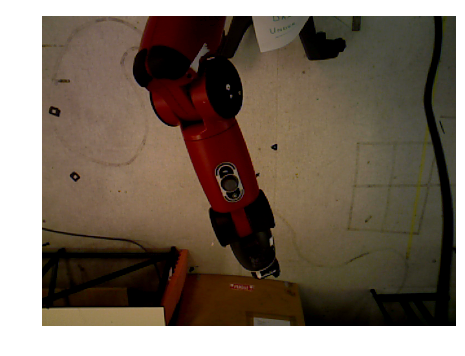

In [14]:
image = data[0]['rgb_image']
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
np.r_[data[0]['position'],data[0]['velocity']]

array([  5.92500079e-01,  -6.45805911e-01,   6.91058344e-01,
         8.88941866e-01,  -6.78403003e-01,   1.49179631e-01,
         1.55584001e+00,   8.23915461e-03,   2.24704217e-03,
         2.50919709e-02,   2.62154920e-02,  -1.12352108e-03,
        -1.31077460e-02,  -8.23915461e-03])

** Prepare data **

In [13]:
prepared_img = lambda img: np.transpose(cv2.resize(img, (network_params['image_width'], network_params['image_height'])),(2,1,0)).flatten()

In [14]:
prepared_obs = np.array([ np.r_[s['position'],s['velocity'], prepared_img(s['rgb_image'])] for s in data ])
prepared_tgt = np.array([ s['ee_point'] for s in data ])
prepared_prc = np.array([ np.eye(s['ee_point'].shape[0]) for s in data ])

prepared_data = {'obs' : prepared_obs, 'tgt': prepared_tgt, 'prc': prepared_prc}

In [15]:
len(prepared_obs[1])
len(prepared_tgt[1])
prepared_prc[1].shape

idx =range(10)
idx_i = idx[0:2]
print idx_i
print prepared_obs[idx_i][0]
print prepared_tgt[idx_i][0]
print prepared_prc[idx_i][0]



[0, 1]
[ 0.59250008 -0.64580591  0.69105834 ...,  2.          0.          0.        ]
[ 1.04573857 -0.09887454  0.45640279]
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


** Save prepared data **

In [16]:
import aml_robot
from aml_io.io_tools import save_data, load_data


In [26]:
save_data(prepared_data,'prepared_data.pkl')

** Load prepared data **

In [19]:
prepared_data = load_data('prepared_data.pkl')

In [27]:
prepared_obs = prepared_data['obs']
prepared_tgt = prepared_data['tgt']
prepared_prc = prepared_data['prc']

** Training **

In [17]:
iterations = 2000 # Epochs
batch_size = 25 
train_size = 2000
batches_per_epoch = np.floor(train_size / batch_size)
idx = range(train_size)
np.random.shuffle(idx)
policy = policy_opt

loss = []
average_loss = 0
for i in range(iterations):
    # Load in data for this batch.
    start_idx = int(i * batch_size %(batches_per_epoch * batch_size))
    idx_i = idx[start_idx:start_idx+batch_size]
    feed_dict = {policy.obs_tensor: prepared_obs[idx_i],
             policy.action_tensor: prepared_tgt[idx_i],
             policy.precision_tensor: prepared_prc[idx_i]}
    
    #t = policy.sess.run(policy.act_op, feed_dict={policy.obs_tensor: np.expand_dims(prepared_obs[idx_i][0], 0)})

    train_loss = policy.solver(feed_dict, policy.sess,device_string="/gpu:0")
    
    
    average_loss += train_loss
    if (i+1) % 50 == 0:
        print('tensorflow iteration %d, average loss %f',
                             i+1, average_loss / 50)
        loss.append(average_loss)
        average_loss = 0

('tensorflow iteration %d, average loss %f', 50, 0.55808202356100078)
('tensorflow iteration %d, average loss %f', 100, 0.046360009871423247)
('tensorflow iteration %d, average loss %f', 150, 0.026024624407291412)
('tensorflow iteration %d, average loss %f', 200, 0.024404298141598703)
('tensorflow iteration %d, average loss %f', 250, 0.02462279237806797)
('tensorflow iteration %d, average loss %f', 300, 0.02327987479045987)
('tensorflow iteration %d, average loss %f', 350, 0.022957498673349619)
('tensorflow iteration %d, average loss %f', 400, 0.023015104047954083)
('tensorflow iteration %d, average loss %f', 450, 0.022323144115507603)
('tensorflow iteration %d, average loss %f', 500, 0.022282790094614029)
('tensorflow iteration %d, average loss %f', 550, 0.02186704345047474)
('tensorflow iteration %d, average loss %f', 600, 0.021457562316209079)
('tensorflow iteration %d, average loss %f', 650, 0.022118523195385934)
('tensorflow iteration %d, average loss %f', 700, 0.02129605924710631

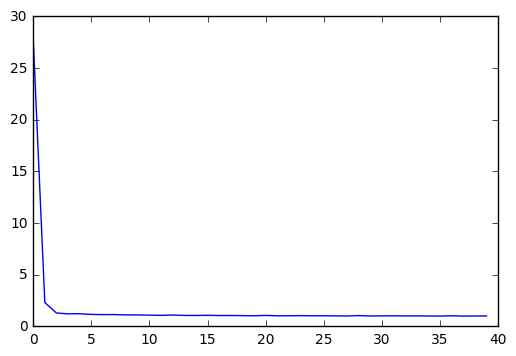

In [18]:
plt.plot(loss)

** Test **

In [19]:
def draw_features(features,image_data):
    
    try:
        (rows,cols,channels) = image_data.shape
        i_feat = 0
        while i_feat < len(features):
            cx = cols/2 + int(float(features[i_feat]*cols)/2)
            cy = rows/2 + int(float(features[i_feat+1]*rows)/2)
            cv2.circle(image_data, (cx,cy), 10, 255)
            i_feat += 2
    except Exception as e:
        print(e)

    return image_data

def show_image(image):

    cv2.imshow("RGB Image window", image)

    cv2.waitKey(1)

In [32]:
features = policy.sess.run(policy.feat_op, feed_dict={policy.obs_tensor: np.expand_dims(prepared_obs[idx_i][0], 0)})
features = features[0]
print(features)

[-0.47934979 -0.479691   -0.01       -0.01       -0.4791885  -0.47968563
 -0.49733329 -0.49917218 -0.48047602 -0.47978559]


In [33]:
image_data = data[0]['rgb_image']
img = draw_features(features,image_data)

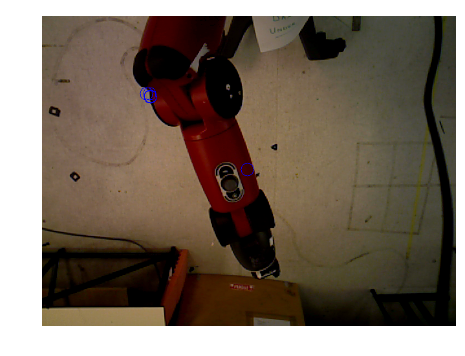

In [34]:
image = data[0]['rgb_image']
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
#np.expand_dims(prepared_obs[i],0)

In [20]:
#err_tmp = err
err = []
for i in range(0,3000):
    features = policy.sess.run(policy.feat_op, feed_dict={policy.obs_tensor: np.expand_dims(prepared_obs[i], 0)})
    point = policy.sess.run(policy.act_op, feed_dict={policy.obs_tensor: np.expand_dims(prepared_obs[i], 0)})
    point = point[0]
    features = features[0]
    image_data = data[i]['rgb_image']
    #image_data = cv2.resize(image_data, (network_params['image_width'], network_params['image_height']))
    img = draw_features(features,image_data)
    show_image(img)
    
    err_i = (data[i]['ee_point'] - point)
    err.append( np.dot(err_i,err_i.T) )
    

('Avg err: ', 0.02781328642917252, ' meters')


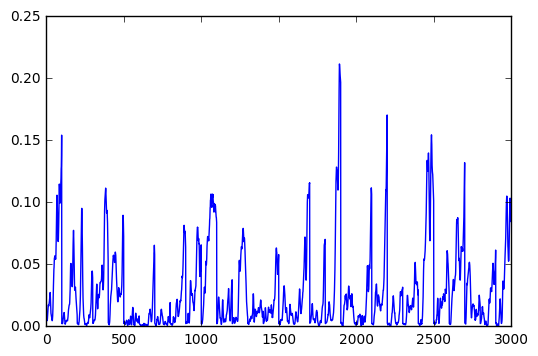

In [33]:
plt.plot(err)
print("Avg err: ", np.sum(err)/len(err), " meters")